In [133]:
import numpy as np
import scipy as sp
import scipy.io
from scipy.stats import unitary_group
from datetime import datetime
import matplotlib.pyplot as plt
import qutip as qt
#from scipy.optimize import curve_fit
import os
import uuid
from itertools import repeat, chain, product, combinations
from joblib import Parallel, delayed
import glob
import time
from EMQST_lib import support_functions as sf
from EMQST_lib import emqst
from EMQST_lib.qst import QST  
from EMQST_lib.povm import POVM
from EMQST_lib import dt
from EMQST_lib import measurement_functions as mf
from EMQST_lib import visualization as vis
from EMQST_lib import overlapping_tomography as ot
from EMQST_lib import photon as ph
from functools import reduce
from cvxopt import matrix, solvers
%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading in data from .mat and .txt file

In [140]:
# Loading in the QST calibration states data.

is_math_file = True
if is_math_file:
    
    calibration_state_path  = "Photon_REM/photonic QREM experimental data v3/calibration states/*"
    calib_state_mat_files = glob.glob(calibration_state_path)[::-1] # To get order HVVH, HLVR, HDVA
    #print(mat_files)
    #mat_files = [glob.glob(p + "/*.mat")[0] for p in paths]

    # Load from math files
    QST_dic_array = [sp.io.loadmat(file) for file in calib_state_mat_files]
    print(QST_dic_array)
    QST_coinc_keys = [list(mat.keys())[6] for mat in QST_dic_array] # 4 corrected coic, 5 accidental counts, 6 Raw counts
    QST_calib_keys = [list(mat.keys())[3] for mat in QST_dic_array]
    print(QST_coinc_keys)
    print(QST_calib_keys)
    QST_coinc_counts = np.array([mat[key].T[0] for mat, key in zip(QST_dic_array, QST_coinc_keys)])
    
    print(QST_coinc_counts)
    
    # Load reconstructed density matrices
    experimental_calibration_states = np.array([mat[key] for mat, key in zip(QST_dic_array, QST_calib_keys)])
    print(experimental_calibration_states)

    # Load the QDT coincidence counts
    qdt_path_nolens = 'Photon_REM/photonic QREM experimental data v3/10 detTomo no lens/detTomo_nolens.mat'
    qdt_path_lens = "Photon_REM/photonic QREM experimental data v3/detector tomography/detTomo_lens.mat"
    #"Photon_REM/photonic QREM experimental data v3/detector tomography/detTomo_lens.mat"
    qdt_conc_dict_nolens = sp.io.loadmat(qdt_path_nolens)
    QDT_conts_nolens = qdt_conc_dict_nolens['detTomo_noLens_coincRaw'].T[0]
    
    qdt_conc_dict_lens = sp.io.loadmat(qdt_path_lens)
    QDT_conts_lens = qdt_conc_dict_lens['detTomo_lens_coincRaw'].T[0]
    
   # print(QDT_conts)

# else: # Is .txt
#     path  = "Photon_REM/photonic QREM experimental data v2/calibration states/*coinc.txt"
#     paths = glob.glob(path)
#     print(paths)
#     QST_coinc_counts = np.array([np.loadtxt(p, skiprows=2) for p in paths])[::-1]
#     print(QST_coinc_counts)

#     # Load reconstructed density matrices
#     qst_path = glob.glob("Photon_REM/photonic QREM experimental data v2/calibration states/*rho.txt")
#     # Read the file content
#     with open(qst_path[0], 'r') as file:
#         lines = file.readlines()
#     #print(lines)
#     # Initialize a list to store the complex matrix
#     complex_matrix = []

#     # Parse each line
#     for line in lines:
#         if line.strip() and '=' not in line:  # Ignore empty lines and the definition line
#             # Replace i with j to make it compatible with Python's complex numbers
#             formatted_line = line.replace('i', 'j').strip()
#             # Split the line by spaces to extract each complex number
#             row = [complex(num) for num in formatted_line.split()]
#             complex_matrix.append(row)
            
#     # Convert the list to a NumPy array
#     calib_rho = np.array(complex_matrix)
#     # Detector tomography coincidence counts
#     qdt_path = "Photon_REM/photonic QREM experimental data v2/detector tomography/detTomo_coinc.txt"
#     QDT_conts = np.loadtxt(qdt_path, skiprows=2)
#     print(QDT_conts)

[{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Jan 13 14:59:16 2025', '__version__': '1.0', '__globals__': [], 'HVVH': array([[ 0.01+0.j  , -0.01-0.06j, -0.01-0.04j, -0.  -0.j  ],
       [-0.01+0.06j,  0.48+0.j  ,  0.46+0.06j,  0.  +0.04j],
       [-0.01+0.04j,  0.46-0.06j,  0.49+0.j  ,  0.01+0.06j],
       [-0.  +0.j  ,  0.  -0.04j,  0.01-0.06j,  0.01+0.j  ]]), 'HVVH_coinc': array([[ 1447.81],
       [63272.43],
       [ 1338.62],
       [64087.95],
       [35540.43],
       [29161.24],
       [32637.57],
       [30936.68],
       [36718.54],
       [62446.97],
       [27817.49],
       [30600.  ],
       [33276.89],
       [43941.89],
       [21213.62],
       [ 2072.92]]), 'HVVH_coincAcc': array([[1729.19],
       [2177.57],
       [1323.38],
       [1959.05],
       [1827.57],
       [1736.76],
       [1742.43],
       [1814.32],
       [1724.46],
       [2012.03],
       [1793.51],
       [1960.  ],
       [1643.11],
       [1713.11],
       [1883.38],
 

In [24]:
path_lens  = "Photon_REM/photonic QREM experimental data v3/13 HVVH with lens/HVVH_lens.mat"
path_no_lens = "Photon_REM/photonic QREM experimental data v3/01 HVVH no lens/HVVH.mat"

lens_dict = sp.io.loadmat(path_lens)
no_lens_dict = sp.io.loadmat(path_no_lens)
hvvh_lens = lens_dict['HVVH_lens_coincRaw'].T[0]
hvvh_no_lens = no_lens_dict['HVVH_coincRaw'].T[0]

coincidene_order_QST = ['HH', 'HV', 'VV', 'VH',
                        'RH', 'RV', 'DV', 'DH',
                        'DR', 'DD', 'RD', 'HD',
                        'VD', 'VL', 'HL', 'RL']

#print(coincidene_order_QST)
for i in range(len(coincidene_order_QST)):
    print(coincidene_order_QST[i], hvvh_lens[i], hvvh_no_lens[i], hvvh_lens[i]/hvvh_no_lens[i])

# print(hvvh_lens)
# print(hvvh_no_lens)
# print(hvvh_lens/hvvh_no_lens)

HH 1208 3177 0.3802329241422726
HV 44567 65450 0.6809320091673032
VV 1029 2662 0.38655146506386173
VH 15002 66047 0.22714127818068952
RH 8811 37368 0.23578998073217727
RV 23029 30898 0.7453233218978574
DV 23426 34380 0.6813845258871437
DH 8489 32751 0.25919819242160547
DR 24248 38443 0.6307520224748329
DD 25508 64459 0.39572441396856917
RD 8598 29611 0.2903650670358988
HD 22071 32560 0.6778562653562653
VD 9303 34920 0.2664089347079038
VL 10581 45655 0.23175993867046327
HL 17651 23097 0.7642118023985799
RL 4829 3524 1.3703178206583428


### Reconstructing the calibration states from coincidences 

Exp reconstruction


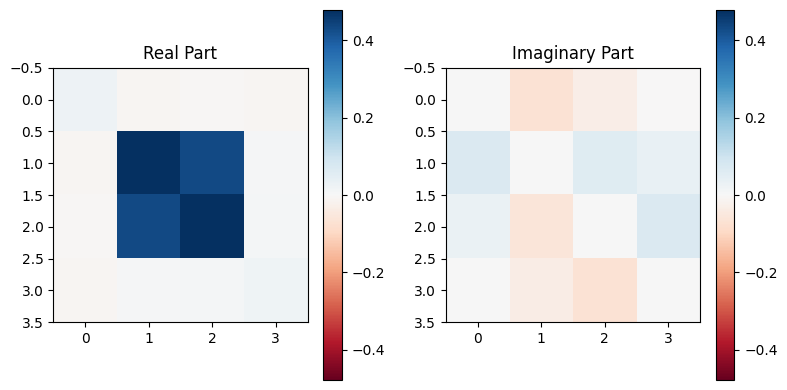

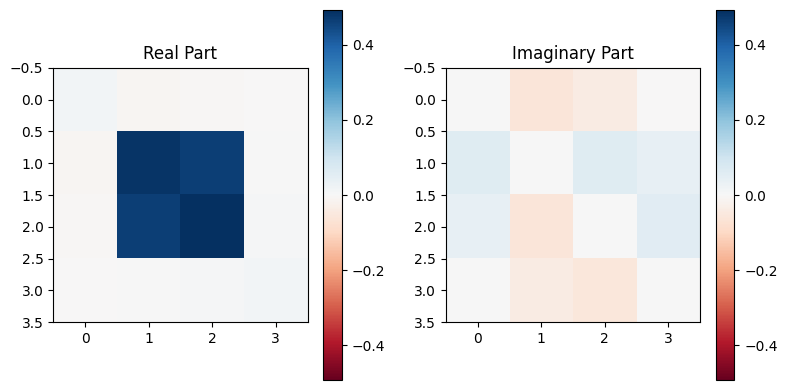

Infidelity between exp and reconstructed sttaes 0.00843826549018023
Infidelity between ideal and reconstructed states 0.09168591499320788
Ideal state


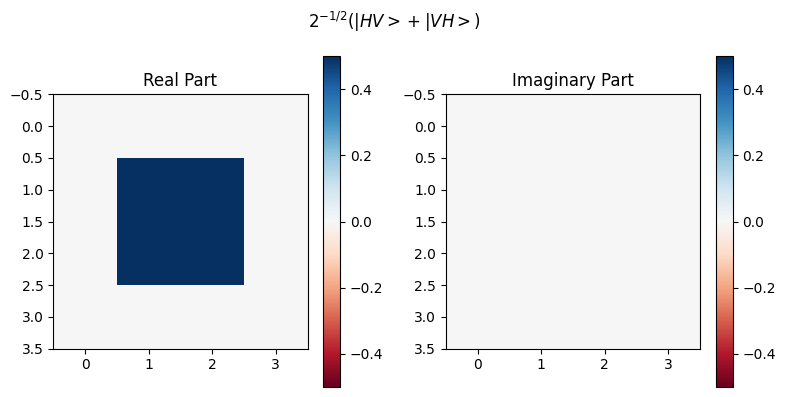

Exp reconstruction


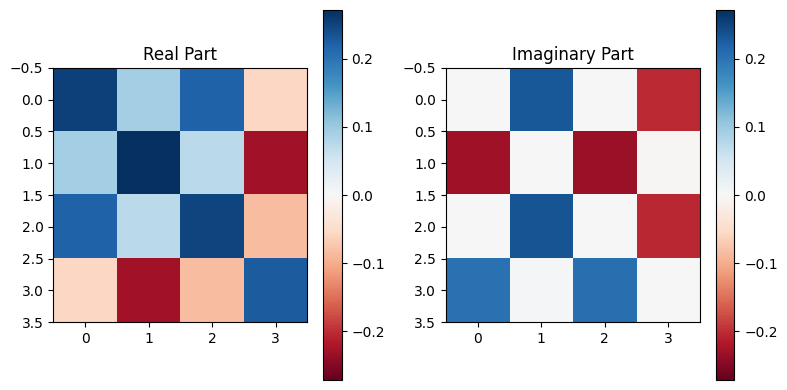

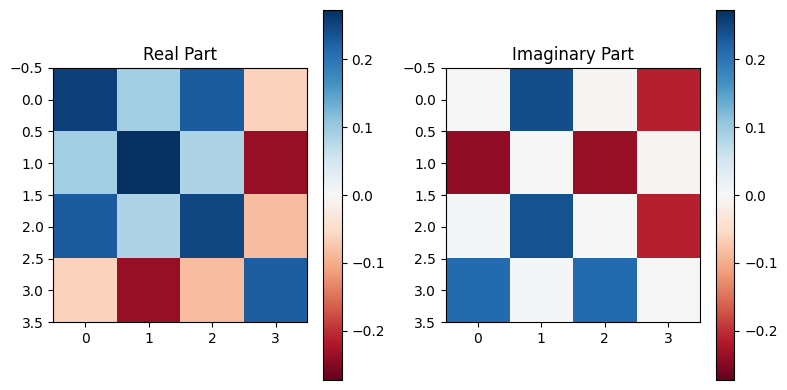

Infidelity between exp and reconstructed sttaes 0.013539229940365827
Infidelity between ideal and reconstructed states 0.08925336965747765
Ideal state


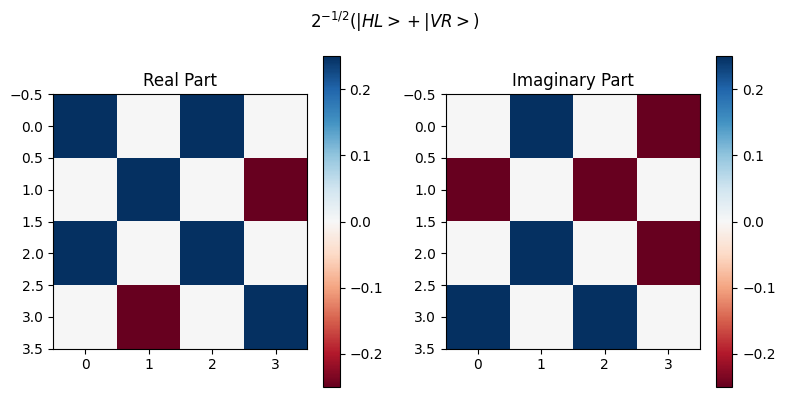

Exp reconstruction


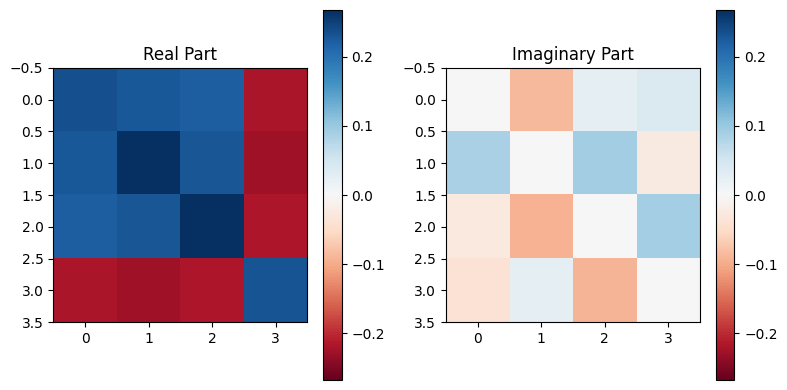

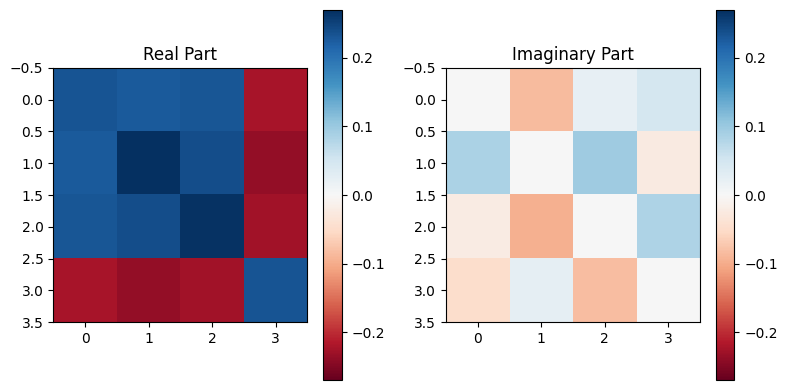

Infidelity between exp and reconstructed sttaes 0.004855168770755092
Infidelity between ideal and reconstructed states 0.08060730978979413
Ideal state


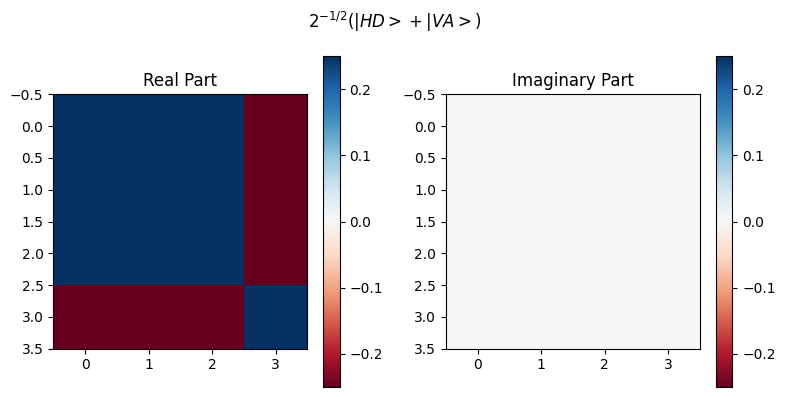

In [141]:
# Define the eigenstates
plus_x = np.array([1, 1]) / np.sqrt(2)
minus_x = np.array([1, -1]) / np.sqrt(2)

plus_y = np.array([1, 1j]) / np.sqrt(2)
minus_y = np.array([1, -1j]) / np.sqrt(2)

plus_z = np.array([1, 0])
minus_z = np.array([0, 1])

# Define density matrices
xup = np.outer(plus_x, np.conj(plus_x)) # D
xdown = np.outer(minus_x, np.conj(minus_x)) # A

yup = np.outer(plus_y, np.conj(plus_y)) # R
ydown = np.outer(minus_y, np.conj(minus_y)) # L

zup = np.outer(plus_z, np.conj(plus_z)) # H
zdown = np.outer(minus_z, np.conj(minus_z)) # V

# Create the ideal calibration states
# [HV + VH, HL + VR, HD + VA]
ideal_calib_states = 1/np.sqrt(2) * np.array([np.kron(plus_z,minus_z) + np.kron(minus_z,plus_z),
                                              np.kron(plus_z,minus_y) + np.kron(minus_z, plus_y),
                                              np.kron(plus_z,plus_x) + np.kron(minus_z,minus_x)
                                              ])
ideal_calib_rho = np.array([np.outer(state,np.conj(state)) for state in ideal_calib_states])

# Create operator count order 
coincidene_order_QST = ['HH', 'HV', 'VV', 'VH',
                        'RH', 'RV', 'DV', 'DH',
                        'DR', 'DD', 'RD', 'HD',
                        'VD', 'VL', 'HL', 'RL']


QST_op_order = ph.photon_label_to_operator(coincidene_order_QST)

title_lables = np.array([r'$2^{-1/2}(|HV>+|VH>)$',r'$2^{-1/2}(|HL>+|VR>)$', r'$2^{-1/2}(|HD>+|VA>)$'])
# Reconstruct the 2 qubit calibration states
rho_list = [ph.coincidence_to_states(mat, QST_op_order) for mat in QST_coinc_counts]
# Compare to the ideal ones.
for rho, rho_ideal, title, calib_rhos in zip(rho_list, ideal_calib_rho, title_lables, experimental_calibration_states):
    print('Exp reconstruction')
    vis.visualize_state(rho)
    vis.visualize_state(calib_rhos)
    print(f'Infidelity between exp and reconstructed sttaes {sf.qubit_infidelity(rho, calib_rhos)}')
    print(f'Infidelity between ideal and reconstructed states {sf.qubit_infidelity(rho_ideal, rho)}')
    print('Ideal state')
    vis.visualize_state(rho_ideal, title = title )
    

#vis.visualize_state(calib_rho)
    
    
# print(QST_coinc_counts)
# mult_vector = np.array([1,1,2,2,1,1,1,1,1,1,1,1,2,2,1,1])

# print(np.einsum('i,ji->ji',mult_vector, QST_coinc_counts))
    
# Save ideal matrix for experimental comparison    
# N_shots = 1000
# print(ideal_calib_rho)
# outcomes = ph.simulate_photon_coincidence_counts(N_shots, ideal_calib_rho, QST_op_order)
# print(outcomes)

# matrix_dict = {"HVVH": ideal_calib_rho[0], 
#                "HLVR": ideal_calib_rho[1], 
#                "HDVA": ideal_calib_rho[2]}
# coinc_dict = {"order": coincidene_order_QST,
#               "Total_orhtogonal_coinc": N_shots,
#               "HVVH_coinc": outcomes[0],
#               "HLVR_coinc": outcomes[1],
#               "HDVA_coinc": outcomes[2]}

#scipy.io.savemat('Photon_REM/deal_calibration_matrices.mat', matrix_dict)
#scipy.io.savemat('Photon_REM/ideal_calibration_coinc.mat', coinc_dict)
#test = sp.io.loadmat('Photon_REM/ideal_calibration_matrices.mat') 
#test_2 = sp.io.loadmat('Photon_REM/ideal_calibration_coinc.mat')


Create the calibration states in two ways

A) From the 2 qubit reconstructions project onto ideal A channel projector and trace down

B) Postselect 1 qubit data from the 2 qubit qst and reconstuct only B channel state

[0.5 +0.j 0.5 +0.j 0.53+0.j 0.5 +0.j 0.47+0.j 0.5 +0.j]
Compare the two calibration states


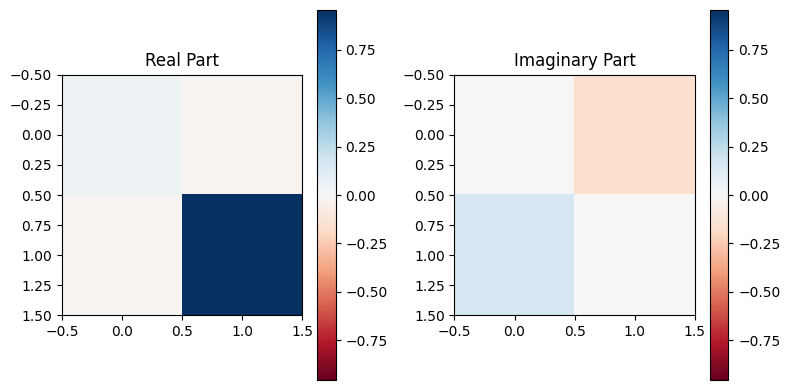

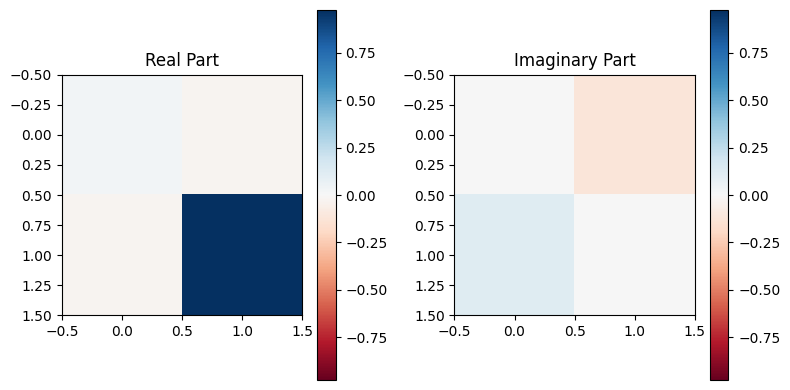

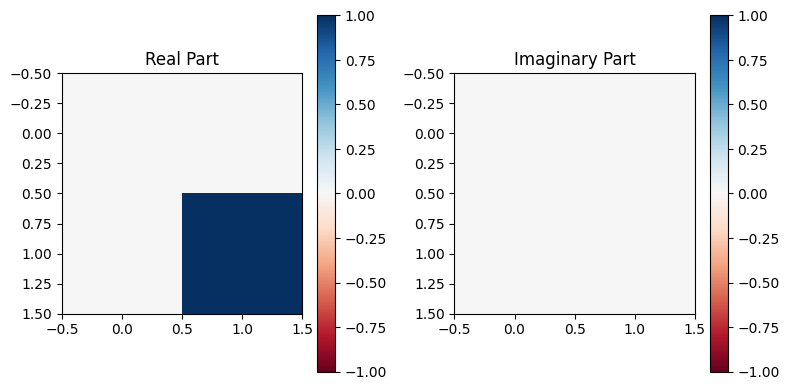

Difference between 1) and 2) for H: 0.0034410914148941263


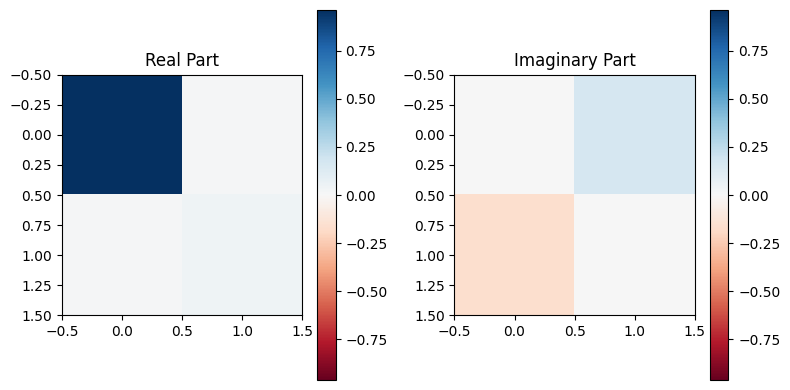

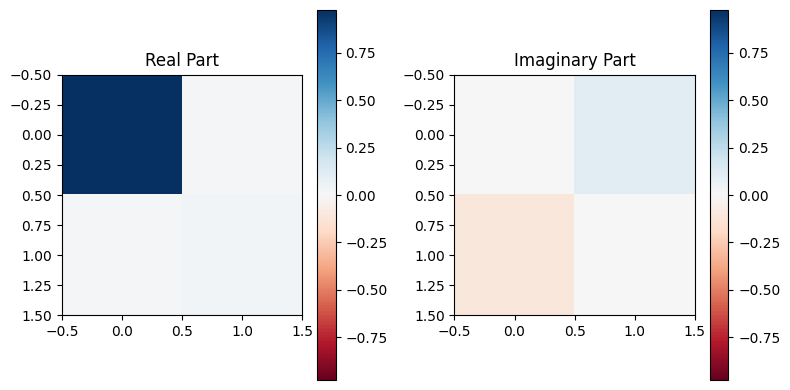

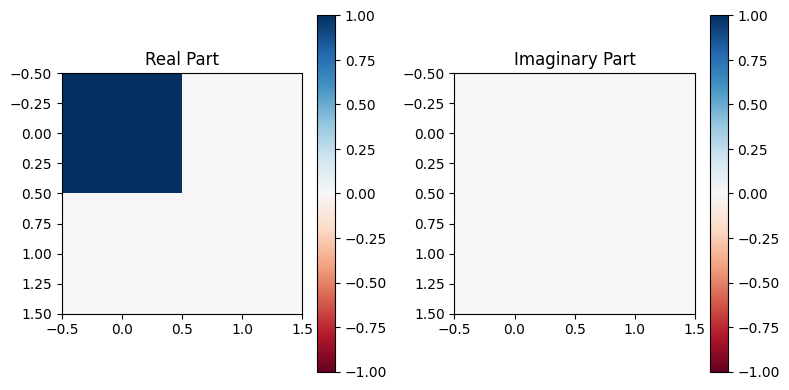

Difference between 1) and 2) for V: 0.002839324455337633


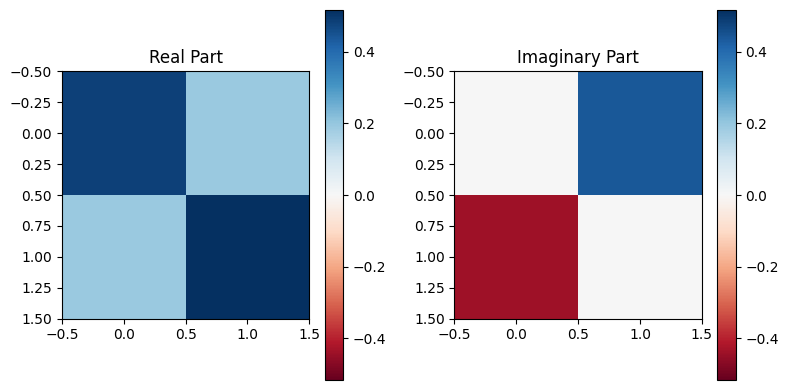

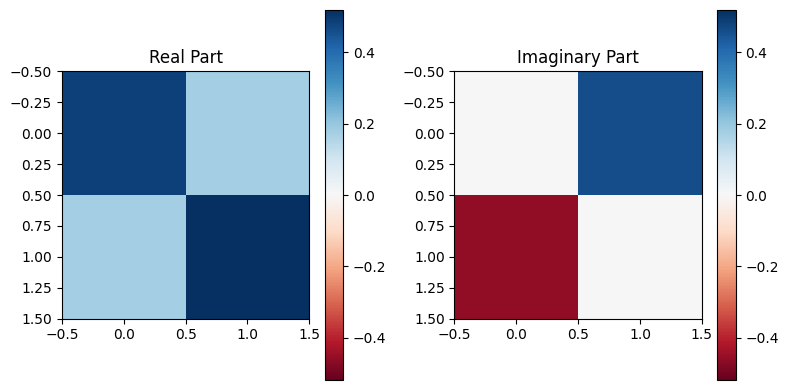

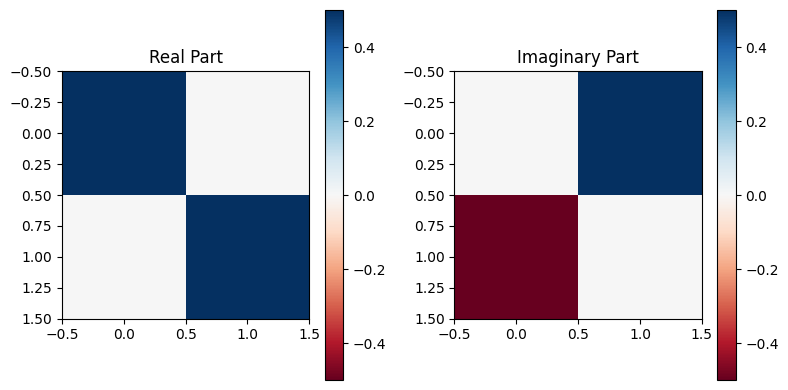

Difference between 1) and 2) for L: 0.0033237632377766113


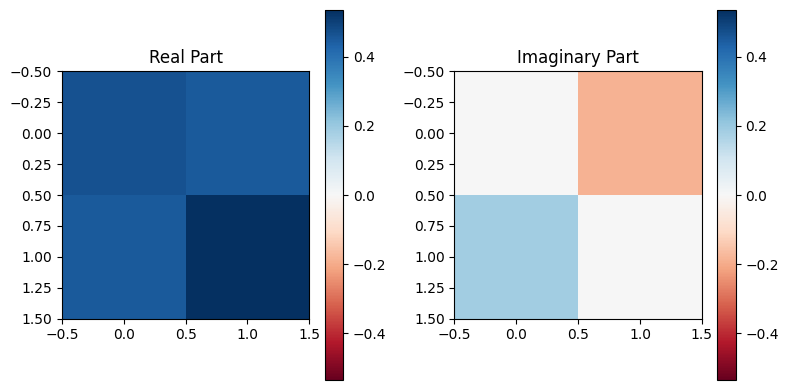

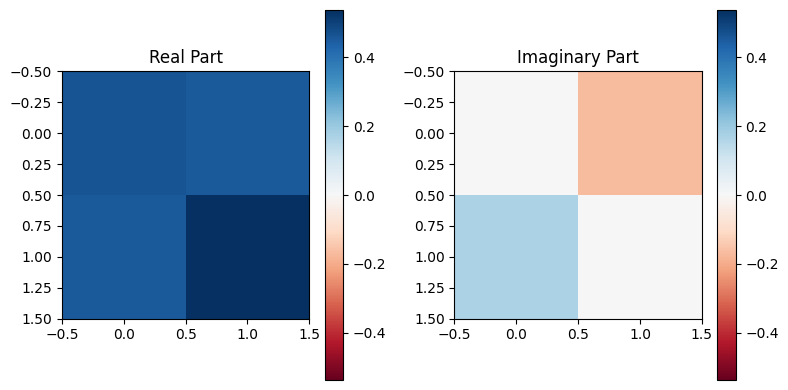

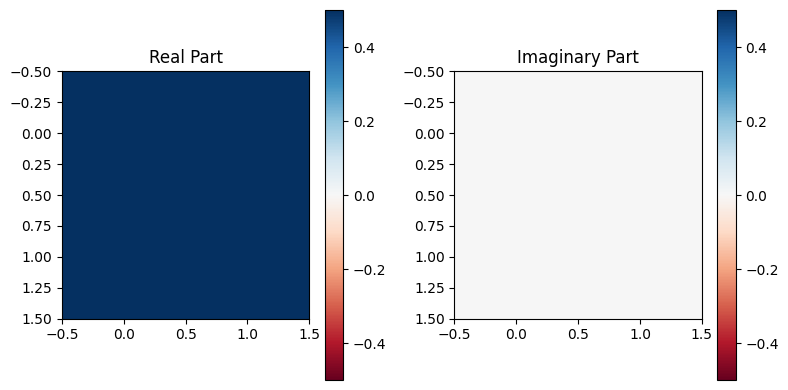

Difference between 1) and 2) for D: 0.0006337793464492592


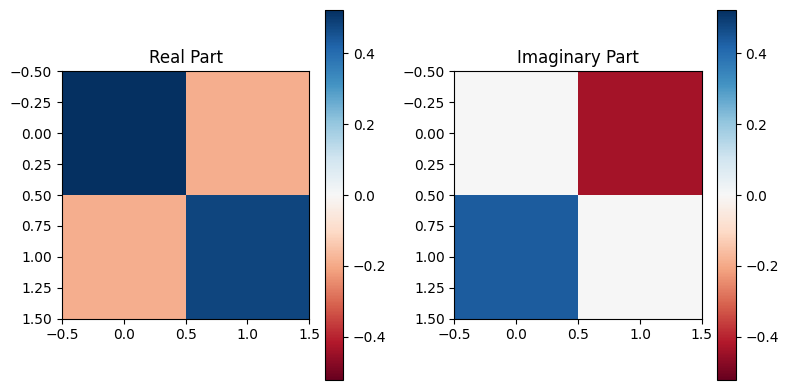

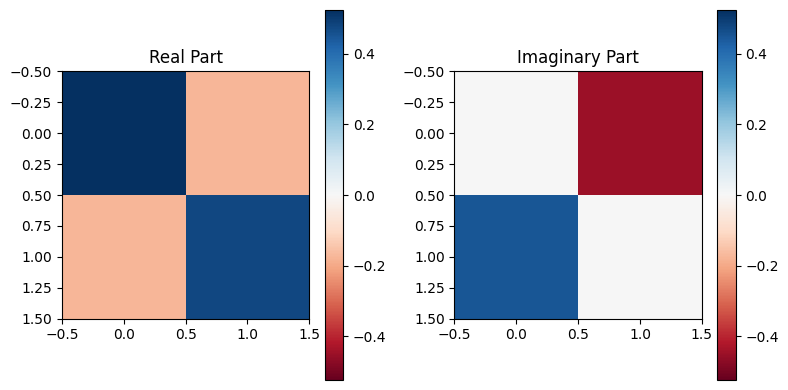

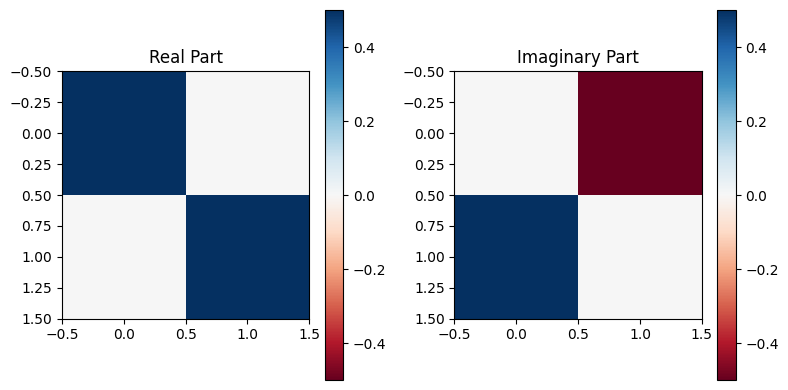

Difference between 1) and 2) for R: 0.0013338580271295974


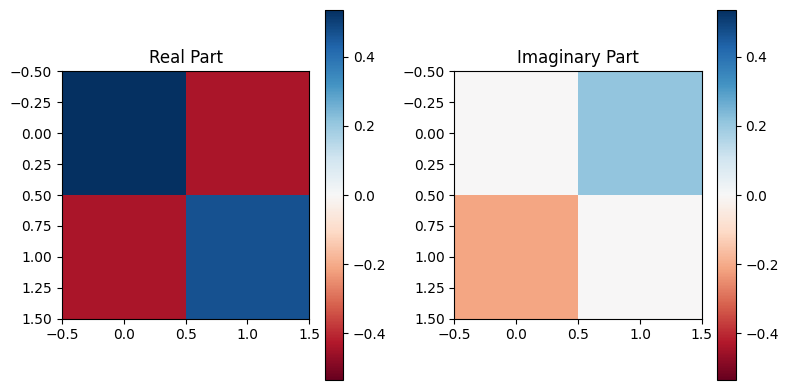

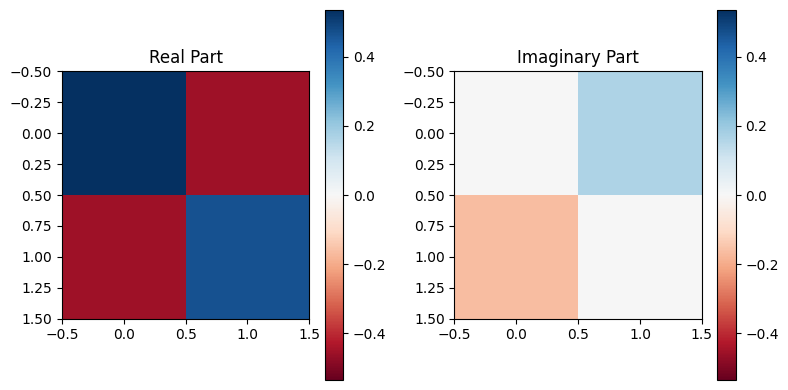

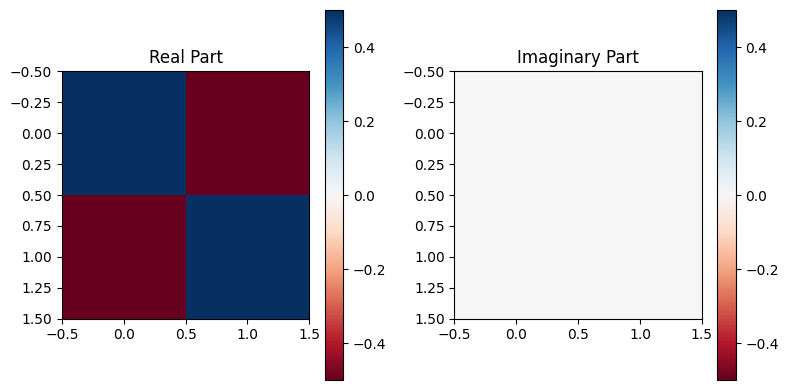

Difference between 1) and 2) for A: 0.0024296447030669466


In [142]:
# Trace out herald states. 
# To do this we need to first know which states was measured by the Harald.
# 1) Project ideal harald projector on the reconstructed state.  
# 2) Trace out the harald qubit, givng the calibration state. 

# Creating the protocol calibration states
state_index_list = [0,0,1,2,1,2]
herald_projector_lables = ['H','V','H', 'H', 'V', 'V']
projector_list = ph.photon_label_to_operator(herald_projector_lables)
reshaped_states = np.array(rho_list).reshape(3,2,2,2,2)

# Apply projectors to the calibration states
projected_rho_list = np.array( [np.einsum('ij,jk,kl->il' , np.kron(proj,np.eye(2)), experimental_calibration_states[rho_index], np.kron(proj,np.eye(2)) ) for rho_index, proj in zip(state_index_list, projector_list)])

# Renormalize the states
print(np.trace(projected_rho_list,axis1=1, axis2=2))
normalized_projected_rho_list = np.array([rho/np.trace(rho) for rho in projected_rho_list])
# Trace down
reshaped_states = normalized_projected_rho_list.reshape(6,2,2,2,2)
traced_down_calib_states = np.einsum('nijik -> njk', reshaped_states)
ideal_labels = ['V','H','L', 'D', 'R', 'A']
ideal_calibration_states = ph.photon_label_to_operator(ideal_labels)
# for state, ideal_state in zip(traced_down_calib_states,ideal_calibration_states):
    # vis.visualize_state(state)
    # vis.visualize_state(ideal_state)
    
    #print(np.trace(state))
    #print(np.trace(state@state))

# Directly reconstruct one qubit states.
# Select the proper samples # order HVDL
sample_index = np.array([[0,1,11,14],
                         [3,2,12,13]])

# Create operator count order 
# coincidene_order_QST = ['HH', 'HV', 'VV', 'VH',
#                         'RH', 'RV', 'DV', 'DH',
#                         'DR', 'DD', 'RD', 'HD',
#                         'VD', 'VL', 'HL', 'RL']
one_qubit_labels = ['H','V','D','L']	
one_qubit_projectors = ph.photon_label_to_operator(one_qubit_labels)

one_qubit_states = np.array([ph.coincidence_to_states(QST_coinc_counts[i,index],one_qubit_projectors,1) for i in range(len(QST_coinc_counts)) for index in sample_index ])
# Reoderd to match protocol calibration states
one_qubit_states = one_qubit_states[[0,1,2,4,3,5]]
print("Compare the two calibration states")
one_qubit_state_labels = ['H','V','L','D', 'R', "A"]
for i in range(len(one_qubit_states)):
    vis.visualize_state(one_qubit_states[i])
    vis.visualize_state(traced_down_calib_states[i])
    vis.visualize_state(ideal_calibration_states[i])
    print(f'Difference between 1) and 2) for {one_qubit_state_labels[i]}: {sf.qubit_infidelity(one_qubit_states[i],traced_down_calib_states[i])}')
    #print(f'Difference between 1) and ideal for {one_qubit_state_labels[i]}: {sf.qubit_infidelity(traced_down_calib_states[i],ideal_calibration_states[i])}')
    #print(f'Difference between 2) and ideal for {one_qubit_state_labels[i]}: {sf.qubit_infidelity(one_qubit_states[i],ideal_calibration_states[i])}')

### QDT reconstruct the POVM with lense 

In [143]:
# Simulate teh QDT measurements based on the recorded calibration states.
n_shots = 70*10**3
A_labels = ['H','V','H','H', 'V', 'V']
B_labels = ['H','V','L','R', 'D', 'A']
calib_label_list = [0,0,1,2,1,2]
A_projectors = ph.photon_label_to_operator(A_labels)
B_projectors = ph.photon_label_to_operator(B_labels)

theory_QDT_coincidence_counts = 2*n_shots*np.real(np.array([[ np.einsum('ij,ji->',experimental_calibration_states[calib_label_list[i]], np.kron(A_projectors[i], B_projectors[j])) for j in range(len(B_labels))] for i in range(len(A_labels))]))

print(theory_QDT_coincidence_counts)
print(QDT_conts_nolens.reshape((6,6)))
print(theory_QDT_coincidence_counts/QDT_conts_nolens.reshape((6,6)))

[[ 1741.37 67724.77 26644.16 42821.98 33120.58 36345.56]
 [68886.45  1647.41 43280.11 27253.75 36096.53 34437.33]
 [35527.45 38197.09 70653.32  3071.22 49765.64 23958.9 ]
 [32524.6  37691.2  23160.41 47055.39 66893.09  3322.7 ]
 [34762.65 31512.81  3329.41 62946.05 21477.61 44797.85]
 [37363.96 32420.24 46493.46 23290.74  3172.54 66611.67]]
[[ 3324 65461 23251 44474 32465 35121]
 [74341  2805 51167 26572 39636 38123]
 [34569 37432 66778  4869 49125 26165]
 [32478 38160 21965 49399 65798  3429]
 [39022 34904  4513 69410 23360 47125]
 [40701 34835 53129 23191  4253 72286]]
[[0.52 1.03 1.15 0.96 1.02 1.03]
 [0.93 0.59 0.85 1.03 0.91 0.9 ]
 [1.03 1.02 1.06 0.63 1.01 0.92]
 [1.   0.99 1.05 0.95 1.02 0.97]
 [0.89 0.9  0.74 0.91 0.92 0.95]
 [0.92 0.93 0.88 1.   0.75 0.92]]


In [144]:
becnhmark_state = experimental_calibration_states[0]
op_label_1 = ["HH", "HV"] 
op_label_2 = ["VH", "VV"]
op_list_1 = ph.photon_label_to_operator(op_label_1)
op_list_2 = ph.photon_label_to_operator(op_label_2)
prob_1 = np.real(np.einsum('ij,mji->m',becnhmark_state, op_list_1))
prob_2 = np.real(np.einsum('ij,mji->m',becnhmark_state, op_list_2))
print(prob_1)
print(prob_2)


[0.01 0.48]
[0.49 0.01]


In [145]:
print(QDT_conts_lens.reshape((6,6)))
print(QDT_conts_nolens.reshape((6,6)))
print( QDT_conts_lens.reshape((6,6))/QDT_conts_nolens.reshape((6,6)))
#print(QDT_conts_ideal.reshape((6,6)) - QDT_conts_lens.reshape((6,6)))
# mult_array = np.array([1,3,1,1,3,3])
# new_QDT_counts_lens = np.einsum("i,ij->ij",mult_array, QDT_conts_lens.reshape((6,6)))
# print(new_QDT_counts_lens)
QDT_conts_nolens = QDT_conts_nolens.reshape((6,6))
QDT_conts_lens = QDT_conts_lens.reshape((6,6))

print(np.sum(QDT_conts_lens, axis = 1))
print(np.max(np.sum(QDT_conts_lens, axis = 1)))
max_count = np.max(np.sum(QDT_conts_lens, axis = 1)) 

modified_QDT_coutns_lens = np.floor([row/np.sum(row) *max_count for row in QDT_conts_lens])
print(modified_QDT_coutns_lens)
for row in modified_QDT_coutns_lens:
    print(np.sum(row))
    
    
    

[[ 1129 43412 17460 26818 21580 22739]
 [13311  1011  9453  4859  8360  6226]
 [21431 21732 41648  1712 28051 17885]
 [20774 22659 15372 28197 41829  1142]
 [ 7631  5546  1398 11717  4095  8709]
 [ 8343  5504  9724  4235  1378 12767]]
[[ 3324 65461 23251 44474 32465 35121]
 [74341  2805 51167 26572 39636 38123]
 [34569 37432 66778  4869 49125 26165]
 [32478 38160 21965 49399 65798  3429]
 [39022 34904  4513 69410 23360 47125]
 [40701 34835 53129 23191  4253 72286]]
[[0.34 0.66 0.75 0.6  0.66 0.65]
 [0.18 0.36 0.18 0.18 0.21 0.16]
 [0.62 0.58 0.62 0.35 0.57 0.68]
 [0.64 0.59 0.7  0.57 0.64 0.33]
 [0.2  0.16 0.31 0.17 0.18 0.18]
 [0.2  0.16 0.18 0.18 0.32 0.18]]
[133138  43220 132459 129973  39096  41951]
133138
[[ 1129. 43412. 17460. 26818. 21580. 22739.]
 [41004.  3114. 29119. 14968. 25752. 19179.]
 [21540. 21843. 41861.  1720. 28194. 17976.]
 [21279. 23210. 15746. 28883. 42847.  1169.]
 [25986. 18886.  4760. 39901. 13945. 29657.]
 [26477. 17467. 30860. 13440.  4373. 40518.]]
133138.0


[[ 3324 65461]
 [74341  2805]
 [34569 37432]
 [32478 38160]
 [39022 34904]
 [40701 34835]]
[[23251 44474]
 [51167 26572]
 [66778  4869]
 [21965 49399]
 [ 4513 69410]
 [53129 23191]]
[[32465 35121]
 [39636 38123]
 [49125 26165]
 [65798  3429]
 [23360 47125]
 [ 4253 72286]]
	Number of MLE iterations: 100, final distance 4.859782021249259e-11
	Number of MLE iterations: 2000, final distance 4.7011928100415545e-09
	Number of MLE iterations: 150, final distance 4.050197816019008e-10
[[ 1129. 43412.]
 [41004.  3114.]
 [21540. 21843.]
 [21279. 23210.]
 [25986. 18886.]
 [26477. 17467.]]
[[17460. 26818.]
 [29119. 14968.]
 [41861.  1720.]
 [15746. 28883.]
 [ 4760. 39901.]
 [30860. 13440.]]
[[21580. 22739.]
 [25752. 19179.]
 [28194. 17976.]
 [42847.  1169.]
 [13945. 29657.]
 [ 4373. 40518.]]
	Number of MLE iterations: 150, final distance 9.76533159890991e-11
	Number of MLE iterations: 200, final distance 3.9935099671595253e-10
	Number of MLE iterations: 200, final distance 7.840228466449162e-12


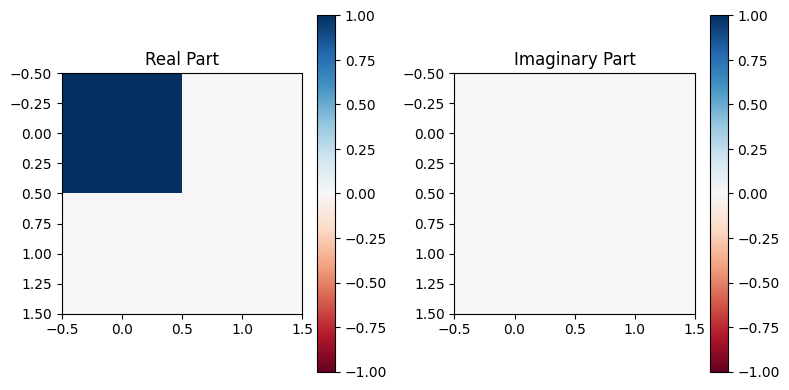

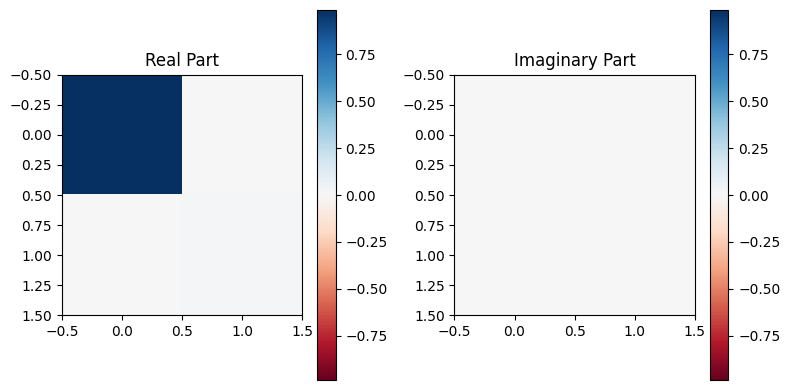

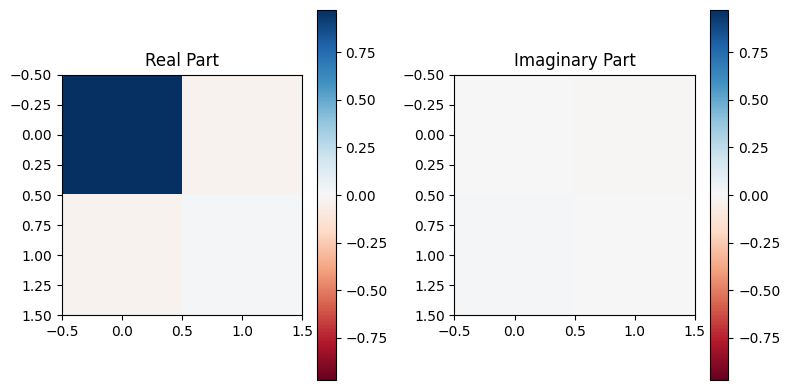

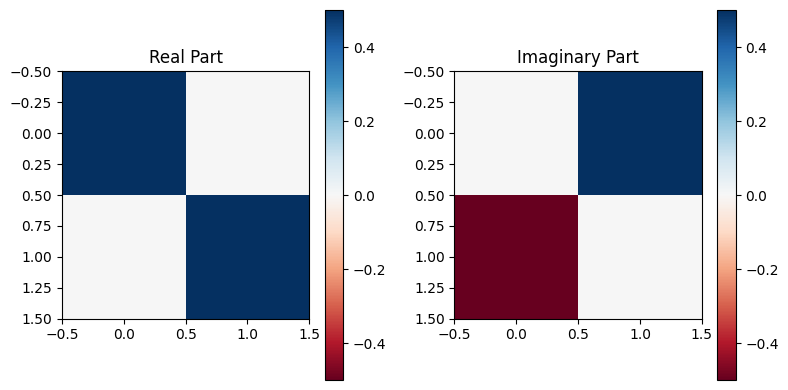

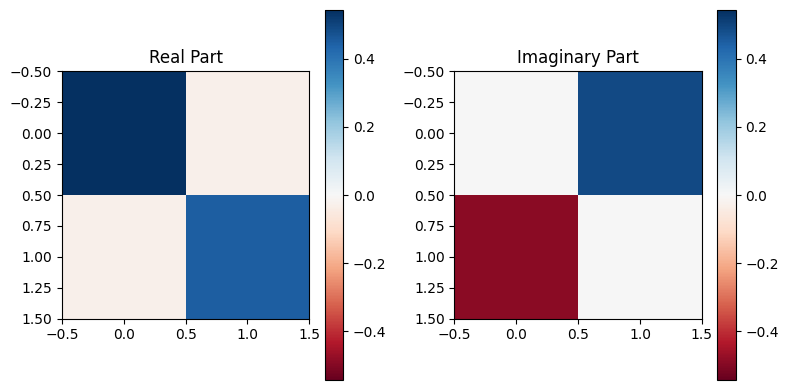

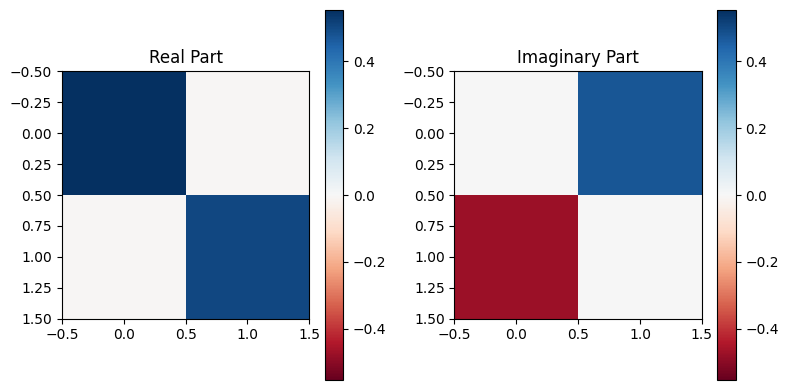

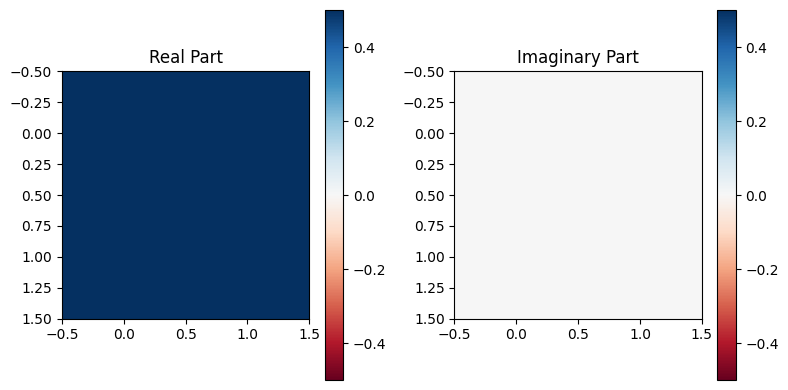

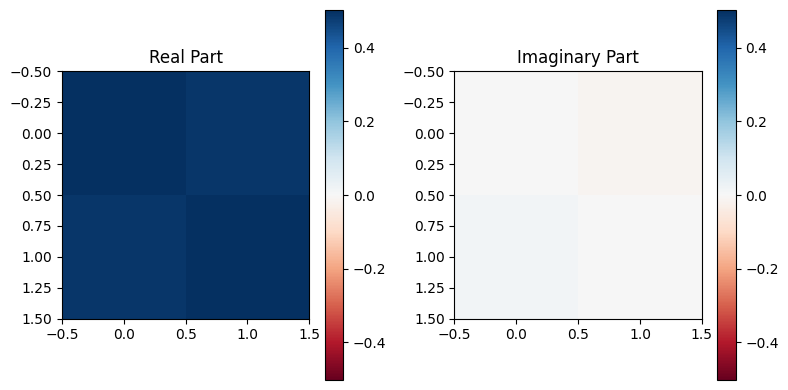

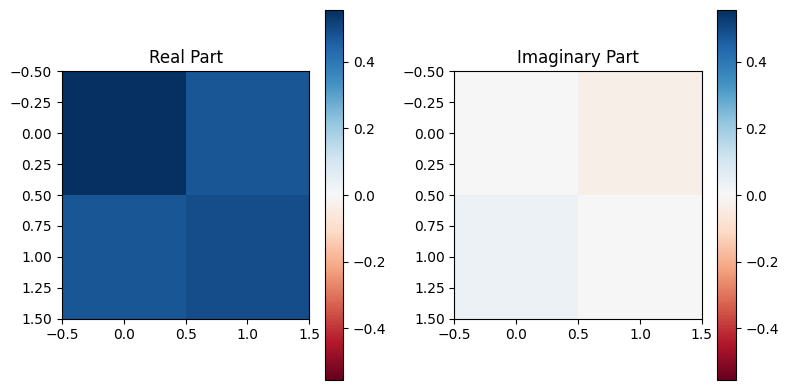

In [146]:
# print(QDT_conts_nolens)
# print(QDT_conts_nolens.reshape((6,6)))
# print(len(traced_down_calib_states))
# print(QDT_conts_nolens/ QDT_conts_lens)
# print(QDT_conts_nolens.reshape((6,6)))
ideal_labels = ['V','H','L', 'D', 'R', 'A']
ideal_calibration_states = ph.photon_label_to_operator(ideal_labels)

#exp_povm = ph.coincidence_to_POVM(QDT_conts.reshape((6,6)), traced_down_calib_states, undercomplete=False)
#exp_povm_ideal_calib_no_lens = ph.coincidence_to_POVM(QDT_conts_ideal.reshape((6,6)), ideal_calibration_states, undercomplete=False)
#exp_povm_ideal_calib_lens = ph.coincidence_to_POVM(QDT_conts_lens.reshape((6,6)), ideal_calibration_states, undercomplete=False)

exp_povm_traced_down_calib_no_lens = ph.coincidence_to_POVM(QDT_conts_nolens.reshape((6,6)), traced_down_calib_states, undercomplete=False)
exp_povm_traced_down_calib_lens = ph.coincidence_to_POVM(modified_QDT_coutns_lens, traced_down_calib_states, undercomplete=False)


true_op_order_list = [['H','V'], ['L','R'],[ 'D','A']]
true_POVMs = np.array([ph.photon_label_to_operator(true_op_order) for true_op_order in true_op_order_list])
#dist = [sf.POVM_distance(povm.get_POVM(), true_povm) for povm, true_povm in zip(exp_povm,true_POVMs)]
#print(f'Distance between true and expected povm {dist}')
#dist_ideal = [sf.POVM_distance(povm.get_POVM(), true_povm) for povm, true_povm in zip(exp_povm_ideal_calib,true_POVMs)]
#print(f'Distance between true and expected povm {dist_ideal}')
for i in range(len(exp_povm_traced_down_calib_no_lens)):
    povm_nolens = exp_povm_traced_down_calib_no_lens[i].get_POVM()
    povm_lens = exp_povm_traced_down_calib_lens[i].get_POVM()
    true = true_POVMs[i]
    vis.visualize_state(true[0])
    vis.visualize_state(povm_nolens[0])
    vis.visualize_state(povm_lens[0])
    #vis.visualize_state(true[1])
    #vis.visualize_state(povm_ideal[1])
    #vis.visualize_state(povm_lens[1])
#print(exp_povm[0].get_POVM())

After having reconstructed the POVM, we want to implement it into the effective experiment.

[21234 23478  5816  8918  8996 21302  6242 25009 23148 22330 20687 42616
  1418 10499 15942  3851]
[21234 23478 17448 26754 26988 21302  6242 75027 23148 22330 20687 42616
  4254 31497 15942  3851]
0.1259615242157972
0.12238072523155774
0.12829567203406844


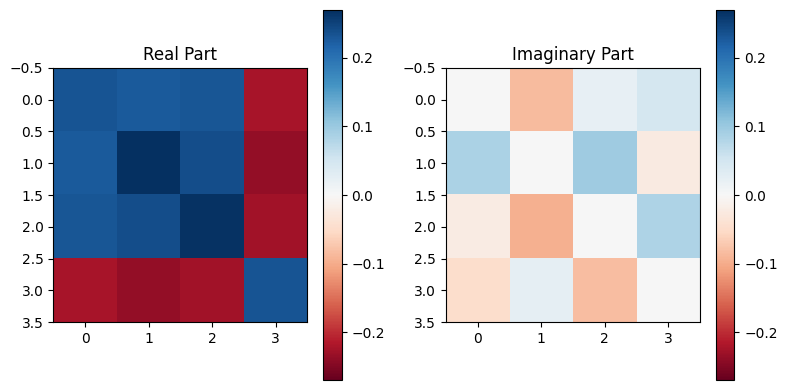

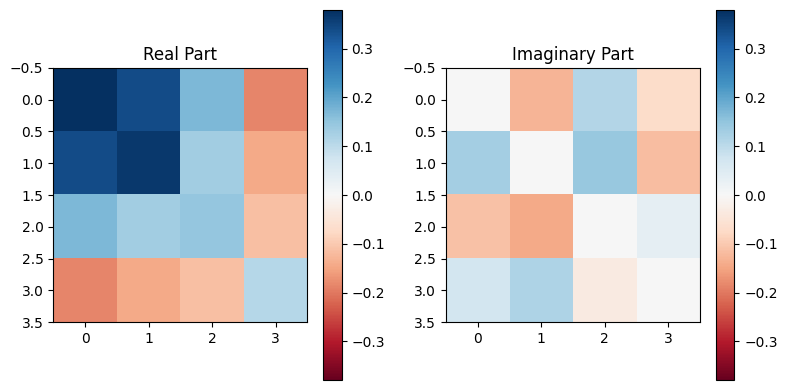

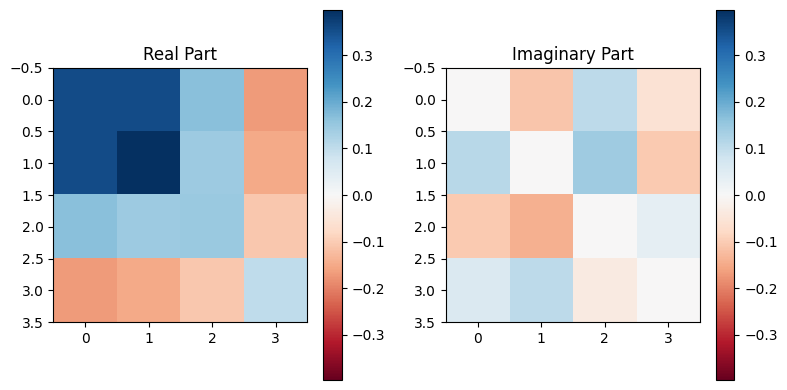

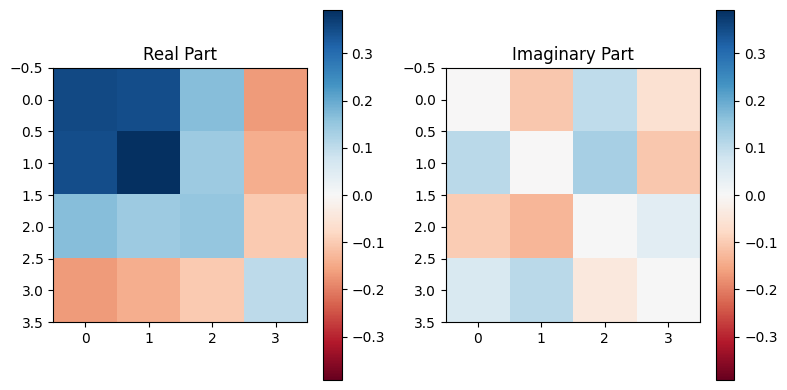

1

In [149]:
path  = "Photon_REM/photonic QREM experimental data v3/12 HDVA with lens/HDVA_lens.mat"
# paths = glob.glob(path)
# benchmark_coinc_counts = np.array([np.loadtxt(p, skiprows=2) for p in paths])

benchmark_dict = sp.io.loadmat(path)
no_correction_rho = benchmark_dict['HDVA_lens']
benchmark_coinc_counts = benchmark_dict['HDVA_lens_coincRaw'].T[0]
print(benchmark_coinc_counts)
# Createing the error mitigated operator list

coincidene_order_QST = ['HH', 'HV', 'VV', 'VH',
                        'RH', 'RV', 'DV', 'DH',
                        'DR', 'DD', 'RD', 'HD',
                        'VD', 'VL', 'HL', 'RL']

# First operators is perfect, second will be taken from reconstruction. 
#[[H,V],[R,L],[D,A]] 
no_lens_dict = {
    'H': exp_povm_traced_down_calib_no_lens[0].get_POVM()[0],
    'V': exp_povm_traced_down_calib_no_lens[0].get_POVM()[1],
    'L': exp_povm_traced_down_calib_no_lens[1].get_POVM()[0],
    'R': exp_povm_traced_down_calib_no_lens[1].get_POVM()[1],
    'D': exp_povm_traced_down_calib_no_lens[2].get_POVM()[0],
    'A': exp_povm_traced_down_calib_no_lens[2].get_POVM()[1]	
}

lens_dict = {
    'H' : exp_povm_traced_down_calib_lens[0].get_POVM()[0],
    'V' : exp_povm_traced_down_calib_lens[0].get_POVM()[1],
    'L' : exp_povm_traced_down_calib_lens[1].get_POVM()[0],
    'R' : exp_povm_traced_down_calib_lens[1].get_POVM()[1],
    'D' : exp_povm_traced_down_calib_lens[2].get_POVM()[0],
    'A' : exp_povm_traced_down_calib_lens[2].get_POVM()[1]
    
}
# Create the operator list for 2 qubit QREM
#coincidence_op_list = np.array([np.kron(ph.photon_label_to_operator(name[0])[0], QREM_op_dict[name[1]]) for name in coincidene_order_QST])
coincidence_op_order_lens = np.array([np.kron(ph.photon_label_to_operator(name[0])[0], lens_dict[name[1]]) for name in coincidene_order_QST])
#QREM_rho = ph.coincidence_to_states(benchmark_coinc_counts, coincidence_op_list)


mult_vector = np.array([1,1,3,3,3,1,1,3,1,1,1,1,3,3,1,1])

new_coinc = np.einsum('i,i->i',mult_vector, benchmark_coinc_counts)
print(new_coinc)

benchmark_ideal_POVM = ph.coincidence_to_states(benchmark_coinc_counts, QST_op_order)
benchmark_lens = ph.coincidence_to_states(benchmark_coinc_counts, coincidence_op_order_lens)
#print(calib_rhos_exp)
noisy_rho = experimental_calibration_states[2]

true_state = ideal_calib_rho[2]
print(sf.qubit_infidelity(benchmark_lens, noisy_rho))
print(sf.qubit_infidelity(no_correction_rho, noisy_rho))
print(sf.qubit_infidelity(benchmark_ideal_POVM, noisy_rho))

#print(f'Comparing accuracy between QREM and no QREM: {sf.qubit_infidelity(QREM_rho, benchmark_ideal_POVM)}')
#print(f'Comparing accuracy between no lense and QREM lense: {sf.qubit_infidelity(benchmark_rho_nolense, QREM_rho)}')
#vis.visualize_state(QREM_rho)
vis.visualize_state(noisy_rho)
vis.visualize_state(benchmark_lens)
vis.visualize_state(no_correction_rho)
vis.visualize_state(benchmark_ideal_POVM)
#vis.visualize_state(benchmark_rho_nolense - QREM_rho)




In [207]:
oincRaw'].T[0]
print(benchmark_coinc_counts)
# Createing the error mitigated operator list

coincidene_order_QST = ['HH', 'HV', 'VV', 'VH',
                        'RH', 'RV', 'DV', 'DH',
                        'DR', 'DD', 'RD', 'HD',
                        'VD', 'VL', 'HL', 'RL']

# First operators is perfect, second will be taken from reconstruction. 
#[[H,V],[R,L],[D,A]] 
no_lens_dict = {
    'H': exp_povm_ideal_calib_no_lens[0].get_POVM()[0],
    'V': exp_povm_ideal_calib_no_lens[0].get_POVM()[1],
    'L': exp_povm_ideal_calib_no_lens[1].get_POVM()[0],
    'R': exp_povm_ideal_calib_no_lens[1].get_POVM()[1],
    'D': exp_povm_ideal_calib_no_lens[2].get_POVM()[0],
    'A': exp_povm_ideal_calib_no_lens[2].get_POVM()[1]	
}

lens_dict = {
    'H' : exp_povm_traced_down_calib_lens[0].get_POVM()[0],
    'V' : exp_povm_traced_down_calib_lens[0].get_POVM()[1],
    'L' : exp_povm_traced_down_calib_lens[1].get_POVM()[0],
    'R' : exp_povm_traced_down_calib_lens[1].get_POVM()[1],
    'D' : exp_povm_traced_down_calib_lens[2].get_POVM()[0],
    'A' : exp_povm_traced_down_calib_lens[2].get_POVM()[1]
    
}
# Create the operator list for 2 qubit QREM
#coincidence_op_list = np.array([np.kron(ph.photon_label_to_operator(name[0])[0], QREM_op_dict[name[1]]) for name in coincidene_order_QST])
coincidence_op_no_lens = np.array([np.kron(ph.photon_label_to_operator(name[0])[0], no_lens_dict[name[1]]) for name in coincidene_order_QST])
#print(coincidence_op_list)

#QREM_rho = ph.coincidence_to_states(benchmark_coinc_counts, coincidence_op_list)

benchmark_ideal_POVM = ph.coincidence_to_states(benchmark_coinc_counts, QST_op_order)
benchmark_no_lens = ph.coincidence_to_states(benchmark_coinc_counts, coincidence_op_no_lens)


#print(f'Comparing accuracy between QREM and no QREM: {sf.qubit_infidelity(QREM_rho, benchmark_ideal_POVM)}')
#print(f'Comparing accuracy between no lense and QREM lense: {sf.qubit_infidelity(benchmark_rho_nolense, QREM_rho)}')
#vis.visualize_state(QREM_rho)
vis.visualize_state(benchmark_no_lens)
vis.visualize_state(no_correction_rho)

#vis.visualize_state(benchmark_rho_nolense - QREM_rho)


SyntaxError: unterminated string literal (detected at line 1) (6860728.py, line 1)

### Simulate photon QREM 

In [12]:

n_QDT_shots = 10**3
n_QST_shots = 10**3
projector_labels = ['H','V','R','D']
projectors = ph.photon_label_to_operator(projector_labels)
# Apply strong depolarizing noise
povm_projectors = POVM(projectors)
depol_POVM = POVM.depolarized_POVM(povm_projectors)
dephasing_POVM = POVM.generate_noisy_POVM(povm_projectors,4)
damped_POVM = POVM.generate_noisy_POVM(povm_projectors,3)


active_POVM = damped_POVM




# Simulate POVM measurements
sim_coincidence = ph.simulate_photon_coincidence_counts(n_QDT_shots, one_qubit_states, active_POVM.get_POVM())
sim_povm_recon = ph.coincidence_to_POVM(sim_coincidence, one_qubit_states)

# Simulate QST measurements
sim_rho_true = sf.generate_random_Hilbert_Schmidt_mixed_state(1)
QST_sim_coinc = ph.simulate_photon_coincidence_counts(n_QST_shots, [sim_rho_true], active_POVM.get_POVM())


QREM_op_dict = {
    'H': sim_povm_recon[0].get_POVM()[0],
    'V': sim_povm_recon[0].get_POVM()[1],
    'L': sim_povm_recon[1].get_POVM()[0],
    'R': sim_povm_recon[1].get_POVM()[1],
    'D': sim_povm_recon[2].get_POVM()[0],
    'A': sim_povm_recon[2].get_POVM()[1]	
}
sim_op_recon_list = np.array([QREM_op_dict[label] for label in projector_labels])

print(f'POVM recon accuracy: {sf.POVM_distance(sim_op_recon_list, active_POVM.get_POVM())}')

sim_rho_recon = ph.coincidence_to_states(QST_sim_coinc, sim_op_recon_list, n_qubits=1)

print(f'Simulated reconstruction accuracy: {sf.qubit_infidelity(sim_rho_recon, sim_rho_true)}')


	Number of MLE iterations: 300, final distance 1.6755133391832544e-10
	Number of MLE iterations: 150, final distance 3.6032288264209456e-13
	Number of MLE iterations: 700, final distance 3.4045517793845903e-10
POVM recon accuracy: 0.001411015427134267
Simulated reconstruction accuracy: 6.852644858224011e-07


Highlight issues:

Benchmark data ratio no lense/lense: [3.04562227 2.97400347 2.48852562 2.99789584 0.53831776 3.25491503
 1.97581362 5.34266985 3.39540385 3.24262462 5.86273115 3.25711275
 2.80928127 1.90410959 2.23022056 2.10591372]
Benchmark coincs: 
[[ 9079. 12012.  7916. 11398.   576. 19536. 11110.  8965. 10047. 19125.
   8243.  9273.  9928.   139. 20324.  8689.]
 [ 2981.  4039.  3181.  3802.  1070.  6002.  5623.  1678.  2959.  5898.
   1406.  2847.  3534.    73.  9113.  4126.]]
Problematic measurement is RH.
QDT coincs: 
[  201. 12256.  5298.  3492.  7957.   233.  3902.  5253.  4361.  5083.
   164.  6145.  1598.  8417. 10223.  5570.  4895.  4330.  6694.  3271.
  6747.  2216.  1144.  3707.]
Problematic is D state with R meaurement: 10223.0
and L state with R measurement: 6694.0
0.5160602124932168 0.5947964923728037
0.5160602124932168 0.5764432081434694
0.5160602124932168 0.4105599031643852
0.45192638853914224 0.5947964923728037
0.45192638853914224 0.5764432081434694
0.45192638853914224 0.4105599031

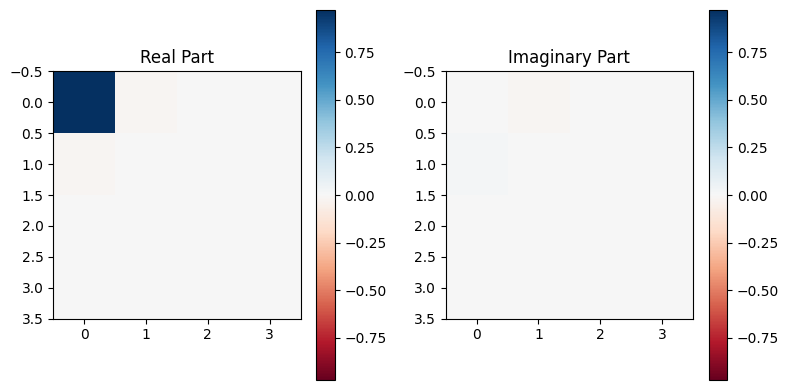

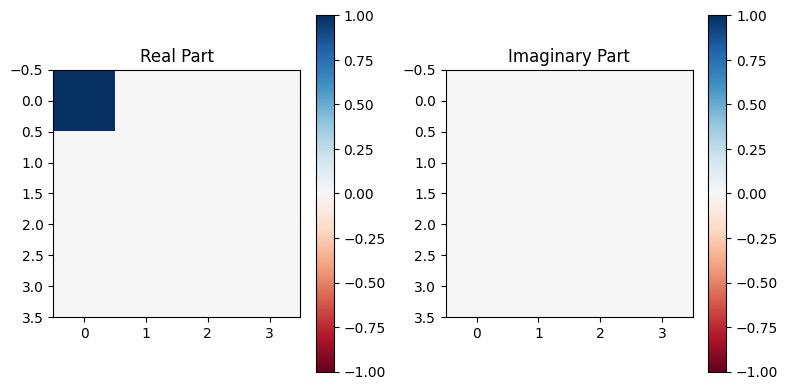

Opeators for HV


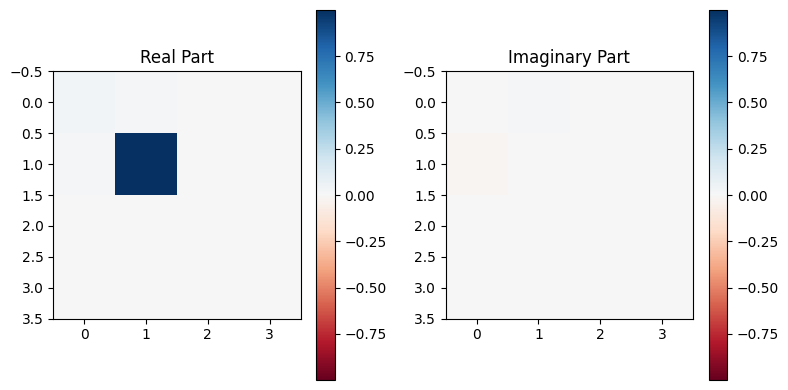

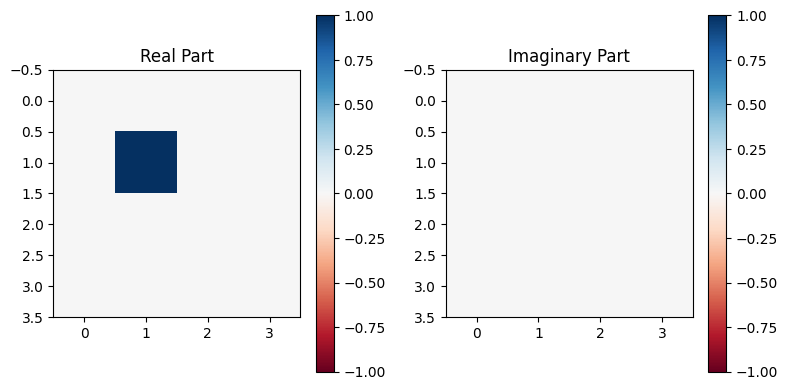

Opeators for VV


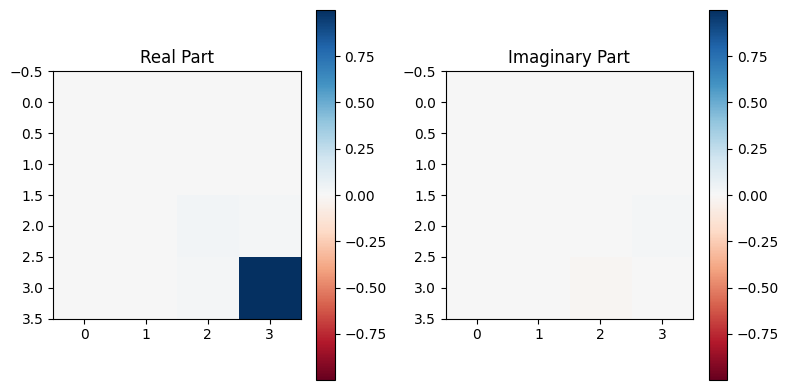

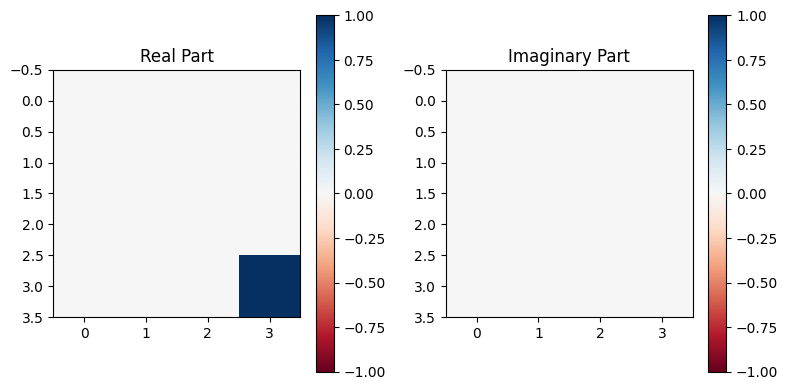

Opeators for VH


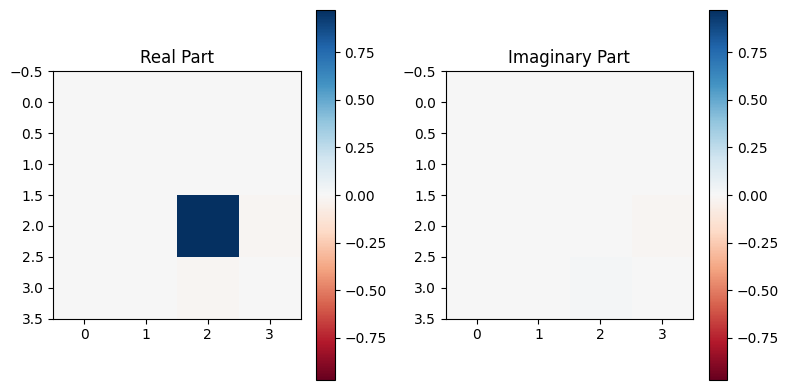

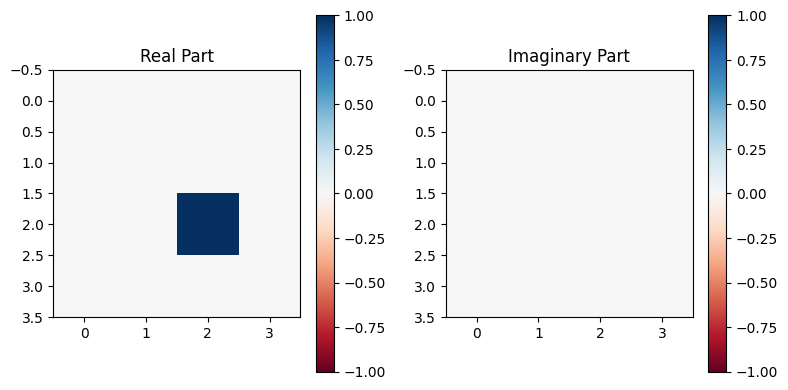

Opeators for RH


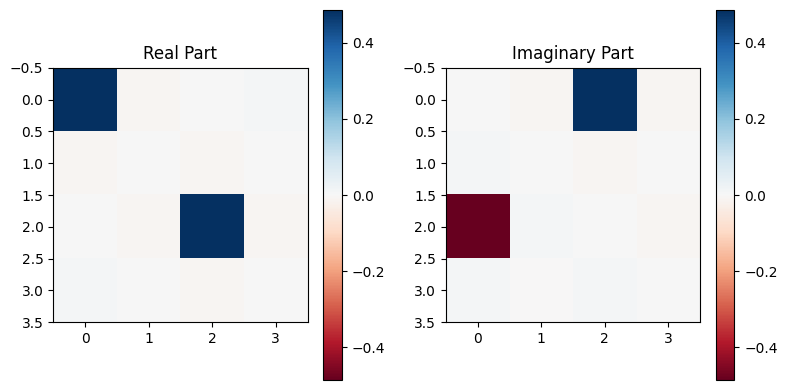

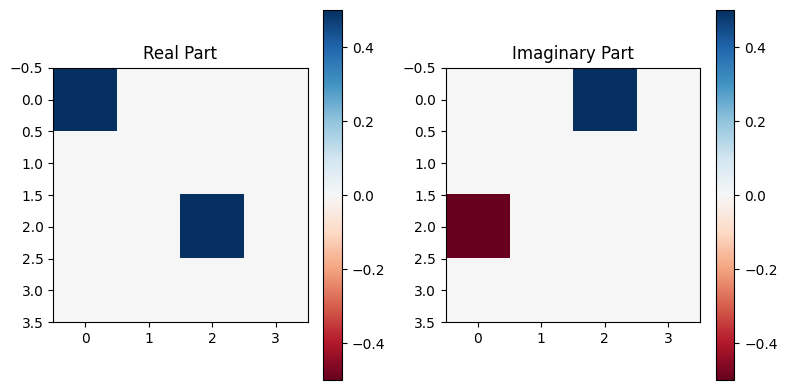

Opeators for RV


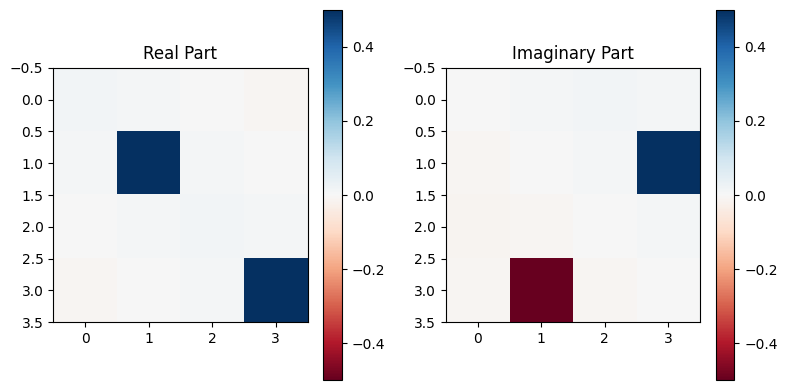

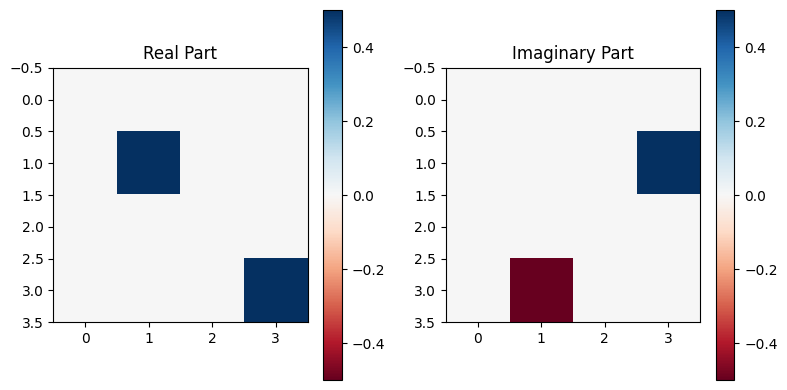

Opeators for DV


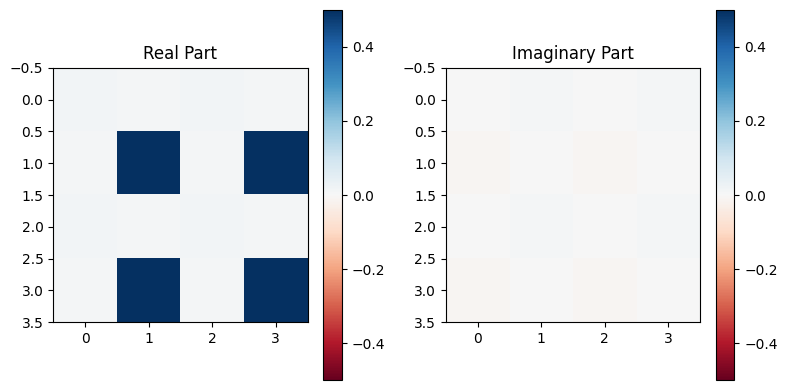

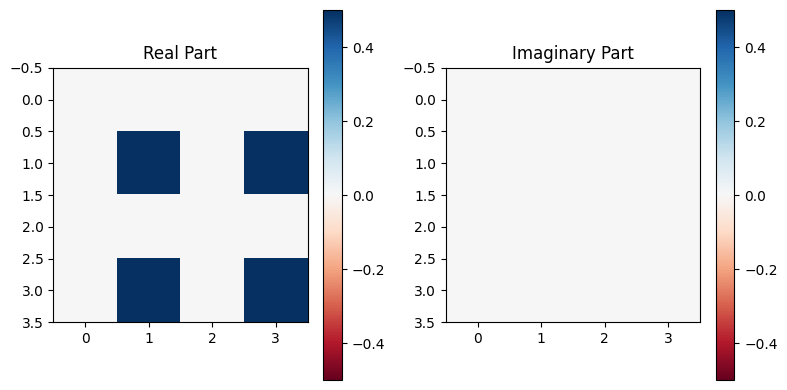

Opeators for DH


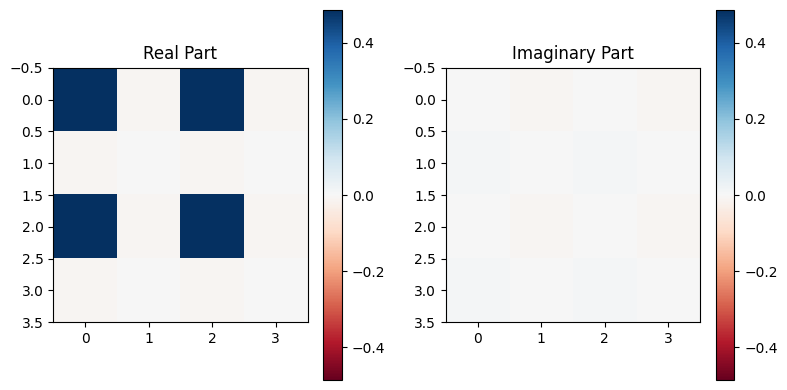

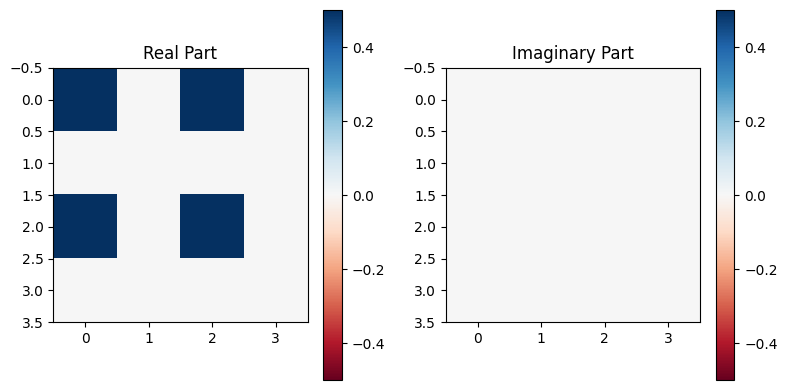

Opeators for DR


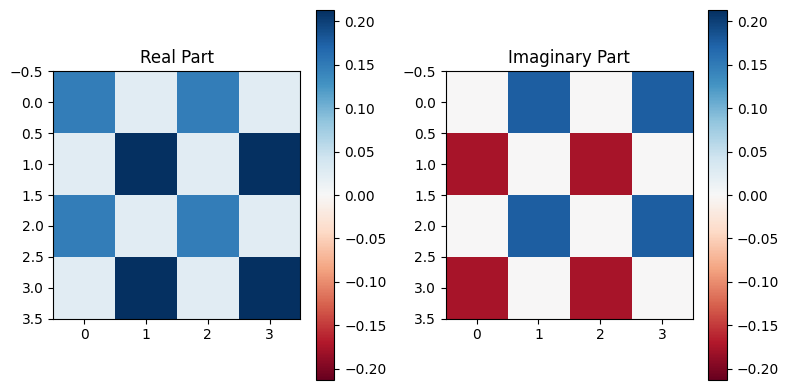

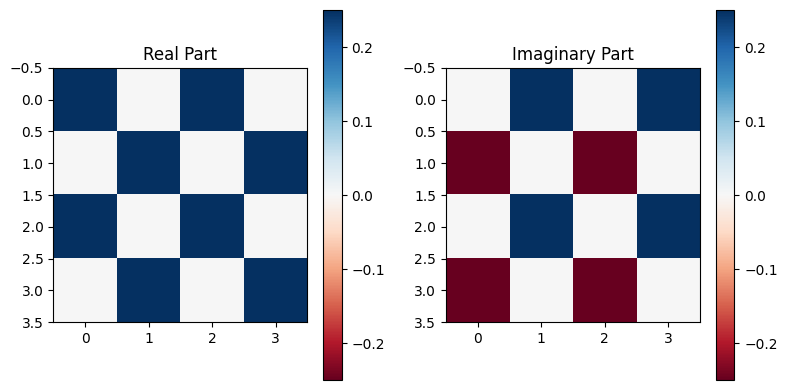

Opeators for DD


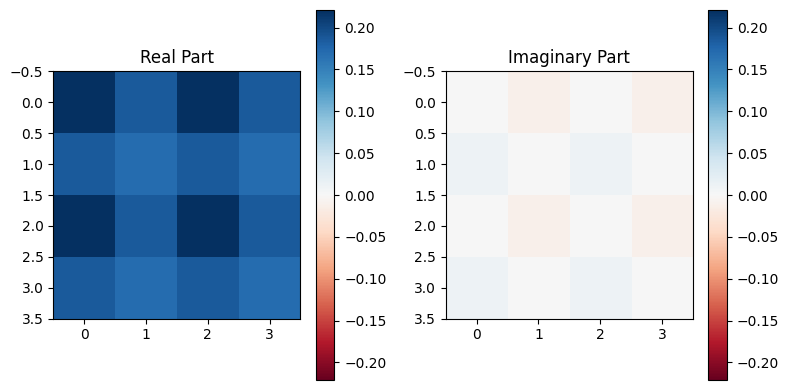

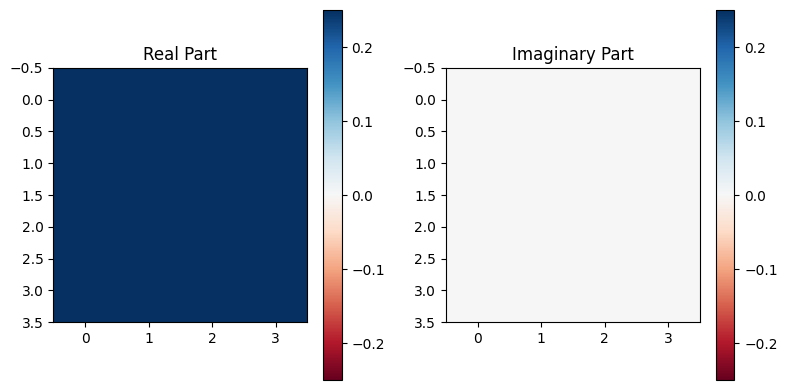

Opeators for RD


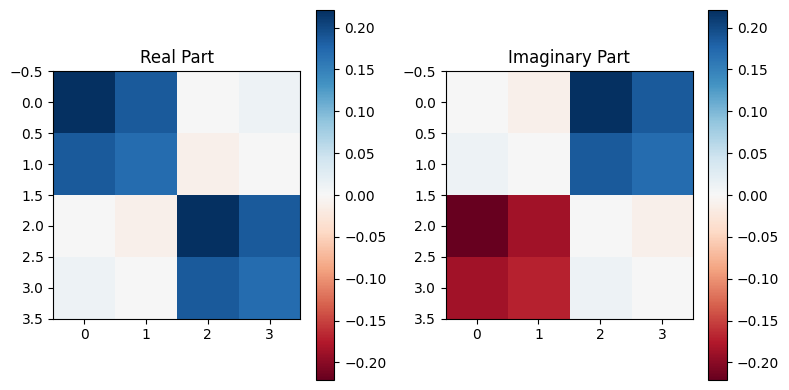

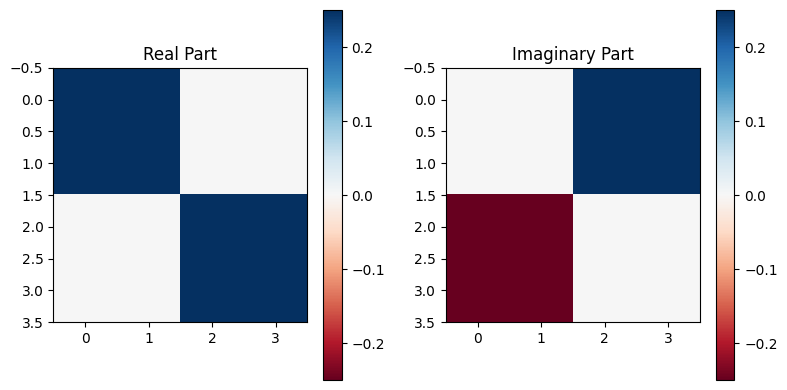

Opeators for HD


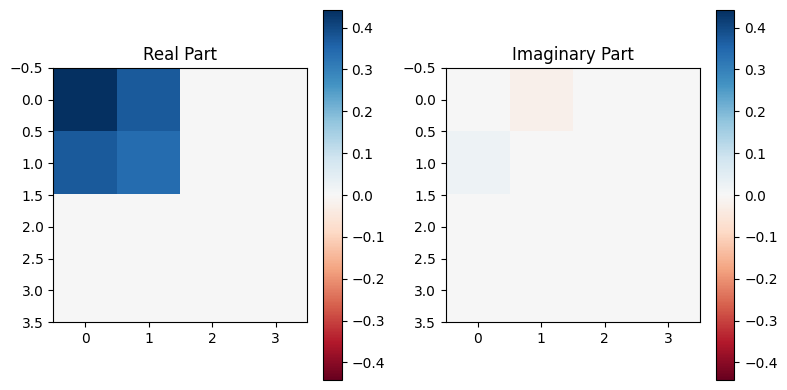

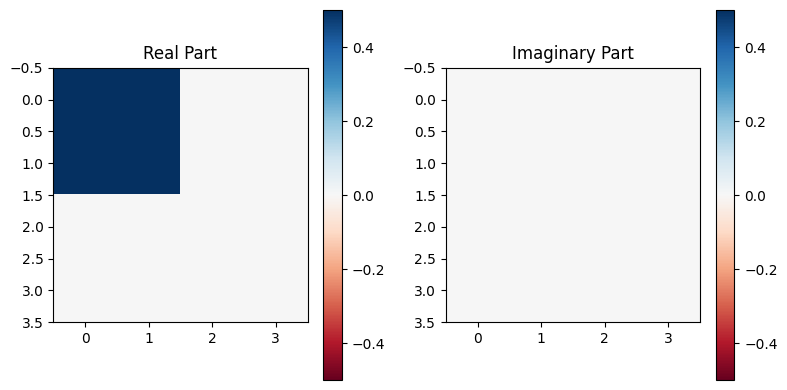

Opeators for VD


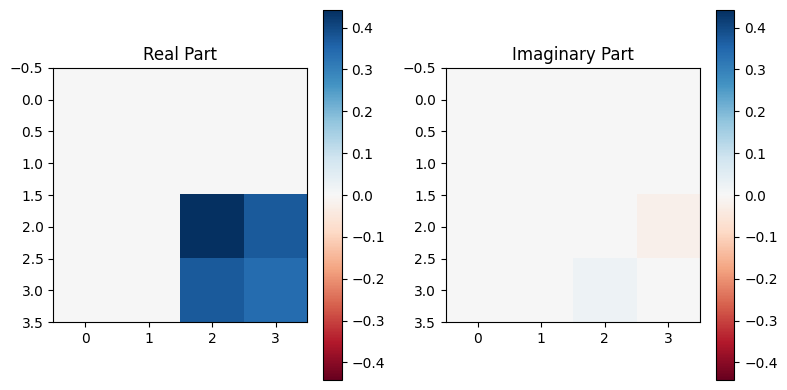

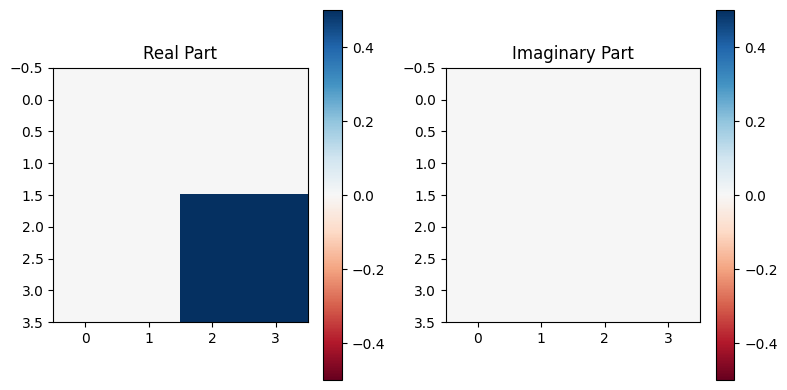

Opeators for VL


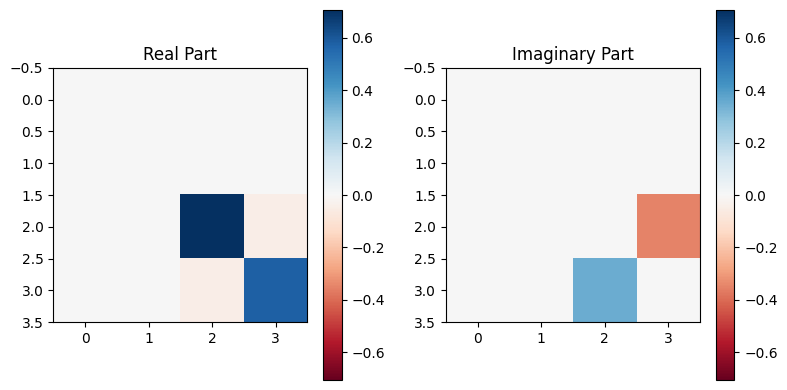

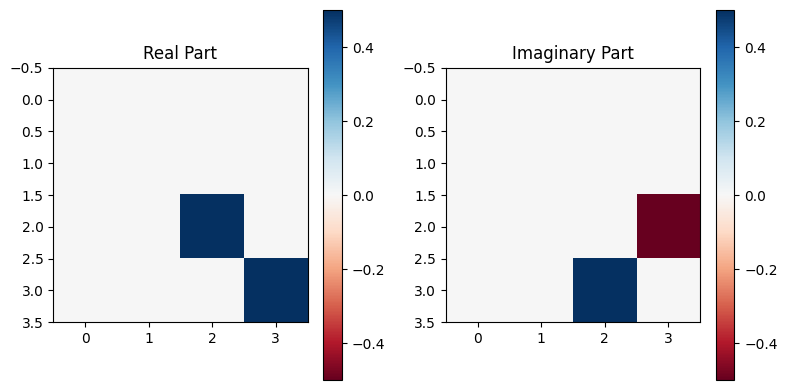

Opeators for HL


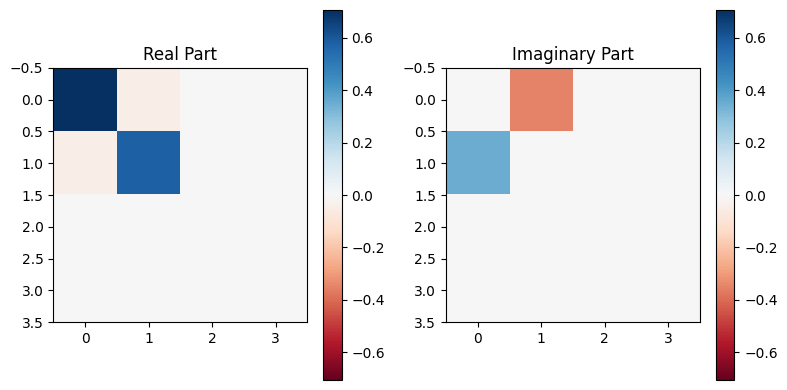

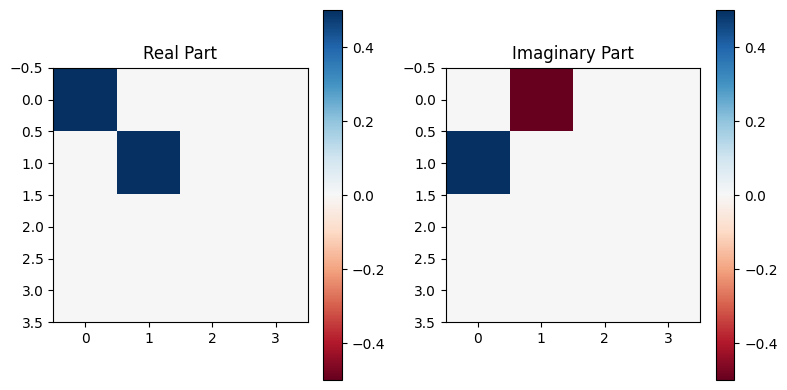

Opeators for RL


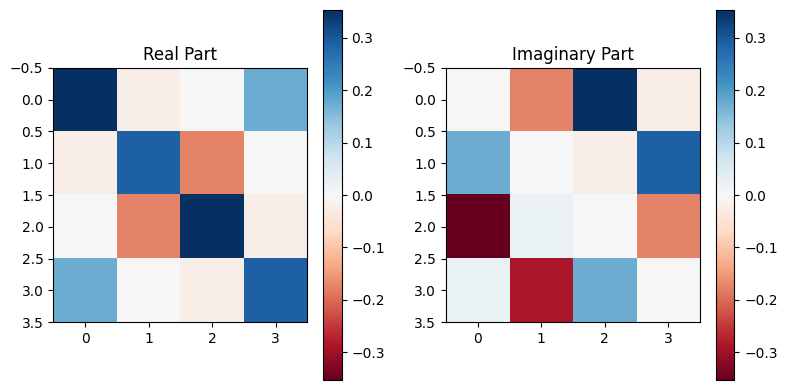

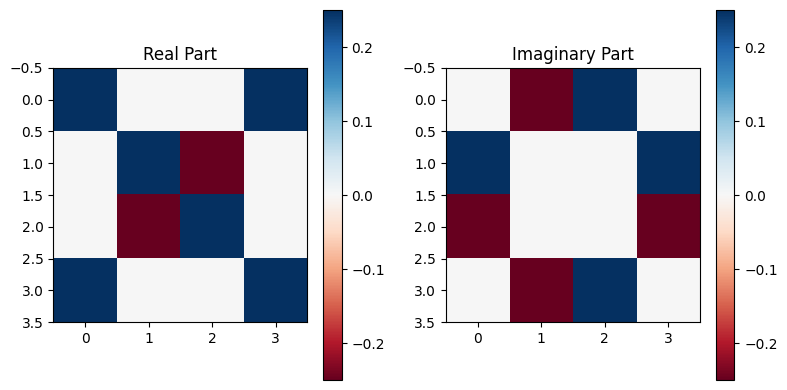

In [13]:
# Benchmark data issue/variability
benchmark_rations = benchmark_coinc_counts[0]/benchmark_coinc_counts[1]
print(f'Benchmark data ratio no lense/lense: {benchmark_rations}')
print(f'Benchmark coincs: \n{benchmark_coinc_counts}')
print(f'Problematic measurement is RH.')


# QDT data issue/variability

print(f'QDT coincs: \n{QDT_conts}')

print(f'Problematic is D state with R meaurement: {QDT_conts[14]}')
print(f'and L state with R measurement: {QDT_conts[-6]}')

temp_rho = sf.generate_random_Hilbert_Schmidt_mixed_state(2)
povm = POVM.generate_Pauli_POVM(2)
for pv in povm:
    hist = pv.get_histogram(temp_rho)
    n_tot = hist[0] + hist[1]
    n_tot2 = hist[0] + hist[2]
    print(n_tot,n_tot2)

for i in range(len(coincidence_op_list)):
    print(f'Opeators for {coincidene_order_QST[i]}')
    vis.visualize_state(coincidence_op_list[i])
    vis.visualize_state(QST_op_order[i])